# Лаба №3
## 000000&FFFFFF

In [1]:
%matplotlib inline
import cv2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import itertools
import time
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import math

In [2]:
def detect_match(algorithm,query_img,train_img,min_match_count):
    query_image = query_img
    train_image = train_img
    keypoints1,descriptors1 = algorithm(query_image,None) #передаємо зображення і маску
    keypoints2,descriptors2 = algorithm(train_image,None)
    msed=np.inf
    if not (isinstance(descriptors1,np.float32)&isinstance(descriptors2,np.float32)):  #нам потрібно np.float32, тому ми перевіряємо тип 
        descriptors1 = np.float32(descriptors1)
        descriptors2 = np.float32(descriptors2)
    
    flann_idx = 1
    index_params = dict(algorithm = flann_idx, trees = 5)
    search_params = dict(checks = 50)

    #-- Step 2: Matching descriptor vectors with a FLANN based matcher
    # Since SURF is a floating-point descriptor NORM_L2 is used
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1,descriptors2,k=2)
    #-- Filter matches using the Lowe's ratio test
    ratio_thresh = 0.7
    good_matches = [m for m,n in matches if m.distance < ratio_thresh*n.distance]
    
    if len(good_matches)>min_match_count:
        src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        
        if M is None:
            return [0],[0],[0],[0],np.inf
    
        matchesMask = mask.ravel().tolist()
        try:
            h,w, _  = query_image.shape
        except ValueError:
            h,w = query_image.shape
        pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)

        dst = cv2.perspectiveTransform(pts,M)

        msed = np.mean([np.sqrt(np.sum(diff)) for diff in (np.power(pts-dst,2))]/(np.sqrt(h**2+w**2)))
        #cv2.polylines(train_image,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        #print( "Not enough matches are found - {}/{}".format(len(good_matches), min_match_count) )
        matchesMask = [0]
        
    return keypoints1, keypoints2, good_matches, matchesMask, msed

In [3]:
alg_dict=dict(brisk=cv2.BRISK_create().detectAndCompute,
              akaze=cv2.AKAZE_create().detectAndCompute)

In [47]:
data_folder = os.path.join(os.curdir,'./Photos/train')
#створюємо сет фотографій
photo_train = [os.path.join(data_folder,file) for file in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder,file)) and os.path.splitext(os.path.join(data_folder,file))[1].lower() in ('.jpg', '.jpeg')]

In [48]:
data_folder = os.path.join(os.curdir,'./Photos/test')
#створюємо сет фотографій
photo_test = [os.path.join(data_folder,file) for file in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder,file)) and os.path.splitext(os.path.join(data_folder,file))[1].lower() in ('.jpg', '.jpeg')]

### Для зошита

In [49]:
train = [cv2.imread(image,0) for image in photo_train]

In [50]:
photo_train.index('././Photos/train/c_122.JPG')

117

In [51]:
photo_test.index('././Photos/test/c_122.JPG')

49

In [52]:
# Write result column for train dataset
Y_train = []
print(photo_train[1])
for i in range(len(photo_train)):
    if(int((photo_train[i].split("_")[1]).split(".")[0]) >= 72):
        Y_train.append(1)
    else:
        Y_train.append(0)

././Photos/train/c_119.jpeg


In [53]:
test = [cv2.imread(image,0) for image in photo_test]

In [54]:
# Write result column for test dataset
Y_test = []
for i in range(len(photo_test)):
    num = int((photo_test[i].split("_")[1]).split(".")[0])
    if(num >= 99):
        Y_test.append(1)
    else:
        Y_test.append(0)

# AKAZE

In [55]:
inliers_matches_akaze_train = dict()
inliers_matches_akaze_train = [[] for i in range(len(train))]

In [56]:
for im_i_idx, image_i in enumerate(train):
    _, __, match, inlier ,msd = detect_match(algorithm=alg_dict['akaze'],query_img=image_i,train_img=train[117],
                                                 min_match_count=10)
    if match==0:
        match=np.inf
    inliers_matches_akaze_train[im_i_idx].append(np.sum(inlier)/(len(match)))

<ipython-input-56-966d08d2b80a>:6: RuntimeWarning: invalid value encountered in long_scalars
  inliers_matches_akaze_train[im_i_idx].append(np.sum(inlier)/(len(match)))


In [57]:
for i in range(len(inliers_matches_akaze_train)):
    for j in range(len(inliers_matches_akaze_train[i])):
        if(math.isnan(inliers_matches_akaze_train[i][j])): 
            inliers_matches_akaze_train[i][j] = 0.0

In [58]:
test = [cv2.imread(image,0) for image in photo_test]

In [59]:
inliers_matches_akaze_test = dict()
inliers_matches_akaze_test = [[] for i in range(len(test))]

In [60]:
for im_i_idx, image_i in enumerate(test):
    _, __, match, inlier ,msd = detect_match(algorithm=alg_dict['akaze'],query_img=image_i,train_img=test[49],
                                                 min_match_count=10)
    if match==0:
        match=np.inf
    inliers_matches_akaze_test[im_i_idx].append(np.sum(inlier)/(len(match)))

<ipython-input-60-996fb7cda7f8>:6: RuntimeWarning: invalid value encountered in long_scalars
  inliers_matches_akaze_test[im_i_idx].append(np.sum(inlier)/(len(match)))


In [61]:
# Change all NaN to 0.0 to avoid errors during training model
for i in range(len(inliers_matches_akaze_test)):
    for j in range(len(inliers_matches_akaze_test[i])):
        if(math.isnan(inliers_matches_akaze_test[i][j])): 
            inliers_matches_akaze_test[i][j] = 0.0

In [69]:
xgb_model_akaze = xgb.XGBClassifier().fit(np.array(inliers_matches_akaze_train), Y_train)
predictions_akaze = xgb_model_akaze.predict(np.array(inliers_matches_akaze_test))

In [70]:
gen_akaze_notebook = predictions_akaze

In [71]:
gen_akaze_notebook

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1])

In [72]:
real_notebook = np.array(Y_test)

In [73]:
real_notebook

array([1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1])

In [74]:
count_akaze = 0
fp_akaze = 0 # false positive
fn_akaze = 0 # false negative
for i in range(len(predictions_akaze)):
    if(predictions_akaze[i] == Y_test[i]):
        count_akaze = count_akaze + 1
    elif(predictions_akaze[i] == 1 and Y_test[i] == 0):
        fp_akaze = fp_akaze + 1
    elif(predictions_akaze[i] == 0 and Y_test[i] == 1):
        fn_akaze = fn_akaze + 1
accuracy_akaze = count_akaze/len(predictions_akaze)
print(accuracy_akaze, fp_akaze, fn_akaze)

0.7 4 11


4


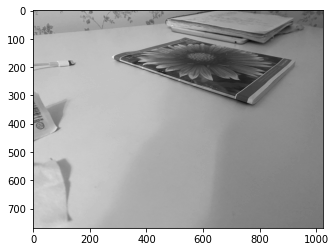

5


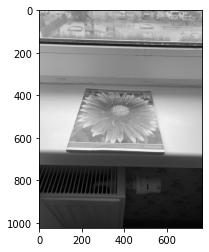

9


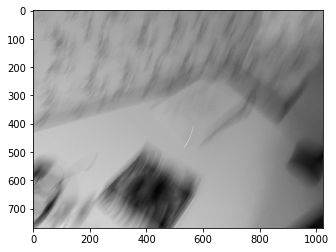

10


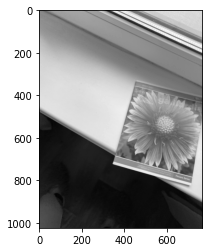

11


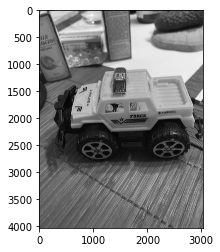

17


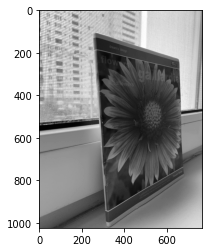

18


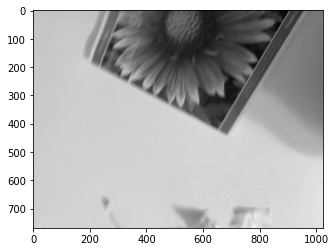

22


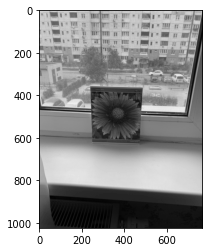

23


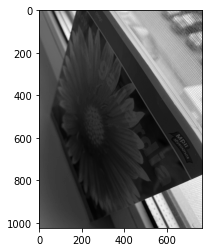

24


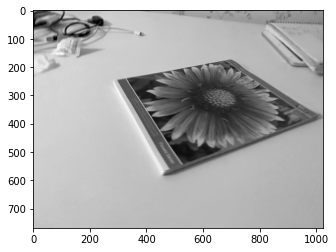

30


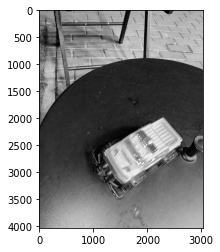

35


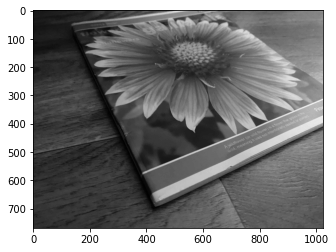

38


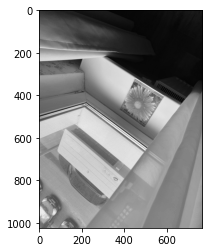

40


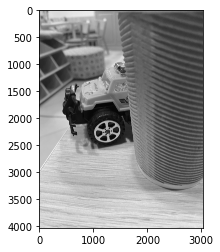

48


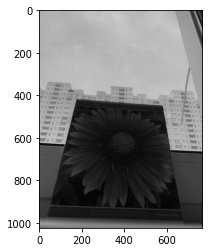

15


<Figure size 432x288 with 0 Axes>

In [68]:
c = 0
with sns.axes_style({'axes.grid': False}):
    for i in range(len(gen_akaze_notebook)):
        if real_notebook[i]!=gen_akaze_notebook[i]:
            c = c + 1
            print(i)
            plt.imshow(test[i], 'gray'),plt.show()
            plt.figure(i+1)
print(c)

### Додатково реалізували RandomForest і GradientBoosting(продемонструємо для зошита, для машинки матимемо аналогічну реалізацію)

In [75]:
%%time
rf_model_akaze  = RandomForestClassifier().fit(np.array(inliers_matches_akaze_train), Y_train)
rf_pred_akaze = rf_model_akaze.predict(np.array(inliers_matches_akaze_test))

CPU times: user 127 ms, sys: 4.15 ms, total: 131 ms
Wall time: 131 ms


In [80]:
# count metrics for RandomForestClassifier()
count_akaze_rf = 0
fp_akaze_rf = 0 # false positive
fn_akaze_rf = 0 # false negative
for i in range(len(rf_pred_akaze)):
    if(rf_pred_akaze[i] == Y_test[i]):
        count_akaze_rf = count_akaze_rf + 1
    elif(rf_pred_akaze[i] == 1 and Y_test[i] == 0):
        fp_akaze_rf = fp_akaze_rf + 1
    elif(rf_pred_akaze[i] == 0 and Y_test[i] == 1):
        fn_akaze_rf = fn_akaze_rf + 1
accuracy_akaze_rf = count_akaze_rf/len(rf_pred_akaze)
print(accuracy_akaze_rf, fp_akaze_rf, fn_akaze_rf)

0.7 4 11


In [82]:
%%time
gb_model_akaze  = GradientBoostingClassifier().fit(np.array(inliers_matches_akaze_train), Y_train)
gb_pred_akaze = gb_model_akaze.predict(np.array(inliers_matches_akaze_test))

CPU times: user 40.7 ms, sys: 2.59 ms, total: 43.3 ms
Wall time: 42.7 ms


In [83]:
# count metrics for GradientBoostingtClassifier()
count_akaze_gb = 0
fp_akaze_gb = 0 # false positive
fn_akaze_gb = 0 # false negative
for i in range(len(gb_pred_akaze)):
    if(gb_pred_akaze[i] == Y_test[i]):
        count_akaze_gb = count_akaze_gb + 1
    elif(gb_pred_akaze[i] == 1 and Y_test[i] == 0):
        fp_akaze_gb = fp_akaze_gb + 1
    elif(gb_pred_akaze[i] == 0 and Y_test[i] == 1):
        fn_akaze_gb = fn_akaze_gb + 1
accuracy_akaze_gb = count_akaze_gb/len(gb_pred_akaze)
print(accuracy_akaze_gb, fp_akaze_gb, fn_akaze_gb)

0.7 4 11


# BRISK

In [84]:
def cleaning(a):
    for i in range(len(a)):
        if(not a[i]):
            return i

In [85]:
inliers_matches_brisk_train = dict()
inliers_matches_brisk_train = [[] for i in range(len(train))]

In [86]:
for im_i_idx, image_i in enumerate(train):
    _, __, match, inlier ,msd = detect_match(algorithm=alg_dict['brisk'],query_img=image_i,train_img=train[117],
                                                 min_match_count=10)
    if match==0:
        match=np.inf
    inliers_matches_brisk_train[im_i_idx].append(np.sum(inlier)/(len(match)))

<ipython-input-86-cad929757404>:6: RuntimeWarning: invalid value encountered in long_scalars
  inliers_matches_brisk_train[im_i_idx].append(np.sum(inlier)/(len(match)))


In [87]:
# Change all NaN to 0.0 to avoid errors during training model
for i in range(len(inliers_matches_brisk_train)):
    for j in range(len(inliers_matches_brisk_train[i])):
        if(math.isnan(inliers_matches_brisk_train[i][j])): 
            inliers_matches_brisk_train[i][j] = 0.0

In [88]:
inliers_matches_brisk_test = dict()
inliers_matches_brisk_test = [[] for i in range(len(train))]

In [89]:
for im_i_idx, image_i in enumerate(test):
    _, __, match, inlier ,msd = detect_match(algorithm=alg_dict['brisk'],query_img=image_i,train_img=test[49],
                                                 min_match_count=10)
    if match==0:
        match=np.inf
    inliers_matches_brisk_test[im_i_idx].append(np.sum(inlier)/(len(match)))

<ipython-input-89-a3b99593840b>:6: RuntimeWarning: invalid value encountered in long_scalars
  inliers_matches_brisk_test[im_i_idx].append(np.sum(inlier)/(len(match)))


In [90]:
inliers_matches_brisk_test = inliers_matches_brisk_test[:cleaning(inliers_matches_brisk_test)]

In [91]:
for i in range(len(inliers_matches_brisk_test)):
    for j in range(len(inliers_matches_brisk_test[i])):
        if(math.isnan(inliers_matches_brisk_test[i][j])): 
            inliers_matches_brisk_test[i][j] = 0.0

In [92]:
xgb_model_brisk = xgb.XGBClassifier().fit(np.array(inliers_matches_brisk_train), Y_train)
predictions_brisk = xgb_model_brisk.predict(np.array(inliers_matches_brisk_test))

In [93]:
gen_brisk_notebook = predictions_brisk 

In [94]:
gen_brisk_notebook 

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1])

In [95]:
real_brisk = np.array(Y_test)

In [96]:
real_brisk

array([1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1])

In [97]:
count_brisk = 0
fp_brisk  = 0 # false positive
fn_brisk  = 0 # false negative
for i in range(len(predictions_brisk)):
    if(predictions_brisk[i] == Y_test[i]):
        count_brisk = count_brisk + 1
    elif(predictions_brisk[i] == 1 and Y_test[i] == 0):
        fp_brisk = fp_brisk + 1
    elif(predictions_brisk[i] == 0 and Y_test[i] == 1):
        fn_brisk = fn_brisk + 1
accuracy_brisk = count_brisk/len(predictions_brisk)
print(accuracy_brisk, fp_brisk, fn_brisk)

0.64 3 15


0


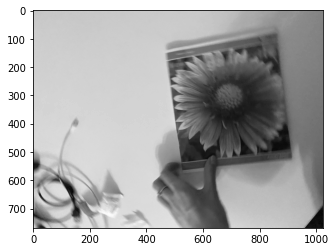

4


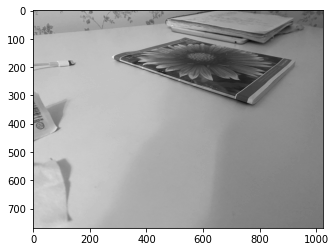

5


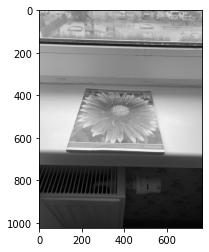

9


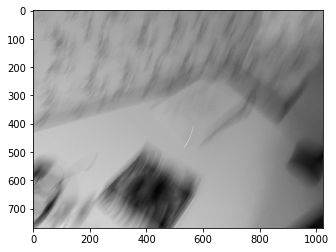

10


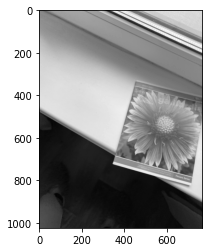

16


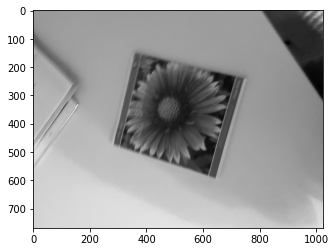

17


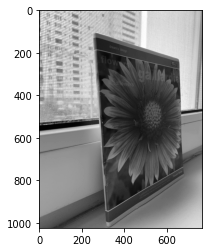

18


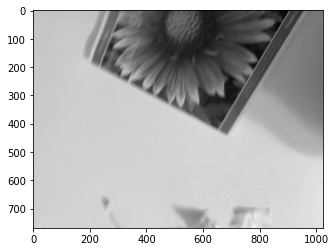

22


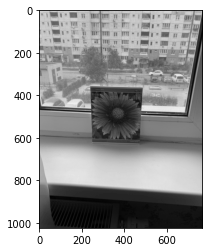

23


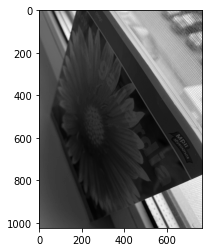

24


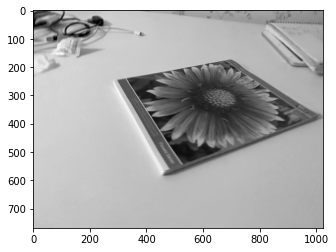

27


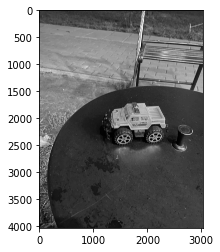

35


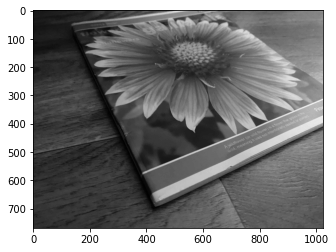

37


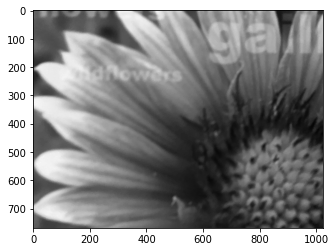

38


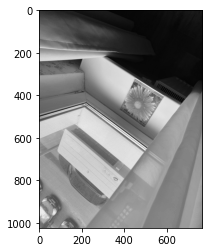

41


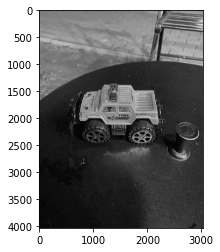

43


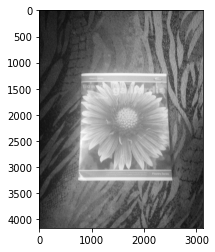

48


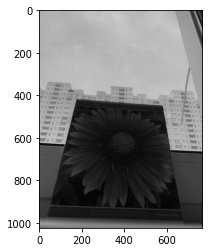

18


<Figure size 432x288 with 0 Axes>

In [98]:
c = 0
with sns.axes_style({'axes.grid': False}):
    for i in range(len(gen_brisk_notebook)):
        if real_brisk[i]!=gen_brisk_notebook[i]:
            c = c + 1
            print(i)
            plt.imshow(test[i], 'gray'),plt.show()
            plt.figure(i+1)
print(c)

In [99]:
%%time
rf_model_brisk  = RandomForestClassifier().fit(np.array(inliers_matches_brisk_train), Y_train)
rf_pred_brisk = rf_model_brisk.predict(np.array(inliers_matches_brisk_test))

CPU times: user 129 ms, sys: 3.4 ms, total: 133 ms
Wall time: 132 ms


In [100]:
# count metrics for RandomForestClassifier()
count_brisk_rf = 0
fp_brisk_rf = 0 # false positive
fn_brisk_rf = 0 # false negative
for i in range(len(rf_pred_brisk)):
    if(rf_pred_brisk[i] == Y_test[i]):
        count_brisk_rf = count_brisk_rf + 1
    elif(rf_pred_brisk[i] == 1 and Y_test[i] == 0):
        fp_brisk_rf = fp_brisk_rf + 1
    elif(rf_pred_brisk[i] == 0 and Y_test[i] == 1):
        fn_brisk_rf = fn_brisk_rf + 1
accuracy_brisk_rf = count_brisk_rf/len(rf_pred_brisk)
print(accuracy_brisk_rf, fp_brisk_rf, fn_brisk_rf)

0.64 3 15


In [101]:
%%time
gb_model_brisk  = GradientBoostingClassifier().fit(np.array(inliers_matches_brisk_train), Y_train)
gb_pred_brisk = gb_model_brisk.predict(np.array(inliers_matches_brisk_test))

CPU times: user 41.1 ms, sys: 1.9 ms, total: 43 ms
Wall time: 41.6 ms


In [103]:
# count metrics for GradientBoostingtClassifier()
count_brisk_gb = 0
fp_brisk_gb = 0 # false positive
fn_brisk_gb = 0 # false negative
for i in range(len(gb_pred_brisk)):
    if(gb_pred_brisk[i] == Y_test[i]):
        count_brisk_gb = count_brisk_gb + 1
    elif(gb_pred_brisk[i] == 1 and Y_test[i] == 0):
        fp_brisk_gb = fp_brisk_gb + 1
    elif(gb_pred_brisk[i] == 0 and Y_test[i] == 1):
        fn_brisk_gb = fn_brisk_gb + 1
accuracy_brisk_gb = count_brisk_gb/len(gb_pred_brisk)
print(accuracy_brisk_gb, fp_brisk_gb, fn_brisk_gb)

0.64 3 15


### Для машинки

In [42]:
train = [cv2.imread(image,0) for image in photo_train]
test = [cv2.imread(image,0) for image in photo_test]

In [43]:
Y_train = []
print(photo_train[1])
for i in range(len(photo_train)):
    if(int((photo_train[i].split("_")[1]).split(".")[0]) < 72):
        Y_train.append(1)
    else:
        Y_train.append(0)

././Photos/train/c_119.jpeg


In [44]:
Y_test = []
for i in range(len(photo_test)):
    num = int((photo_test[i].split("_")[1]).split(".")[0])
    if(num < 99):
        Y_test.append(1)
    else:
        Y_test.append(0)

In [45]:
photo_train.index('././Photos/train/c_48.jpeg')

56

In [46]:
photo_test.index('././Photos/test/c_79.JPG')

34

# AKAZE

In [47]:
inliers_matches_akaze_train = dict()
inliers_matches_akaze_train = [[] for i in range(len(train))]

In [48]:
for im_i_idx, image_i in enumerate(train):
    _, __, match, inlier ,msd = detect_match(algorithm=alg_dict['akaze'],query_img=image_i,train_img=train[55],
                                                 min_match_count=10)
    if match==0:
        match=np.inf
    inliers_matches_akaze_train[im_i_idx].append(np.sum(inlier)/(len(match)))

<ipython-input-48-150976d5fbce>:6: RuntimeWarning: invalid value encountered in long_scalars
  inliers_matches_akaze_train[im_i_idx].append(np.sum(inlier)/(len(match)))


In [49]:
for i in range(len(inliers_matches_akaze_train)):
    for j in range(len(inliers_matches_akaze_train[i])):
        if(math.isnan(inliers_matches_akaze_train[i][j])): 
            inliers_matches_akaze_train[i][j] = 0.0

In [50]:
test = [cv2.imread(image,0) for image in photo_test]

In [51]:
inliers_matches_akaze_test = dict()
inliers_matches_akaze_test = [[] for i in range(len(test))]

In [ ]:
for im_i_idx, image_i in enumerate(test):
    _, __, match, inlier ,msd = detect_match(algorithm=alg_dict['akaze'],query_img=image_i,train_img=test[34],
                                                 min_match_count=10)
    if match==0:
        match=np.inf
    inliers_matches_akaze_test[im_i_idx].append(np.sum(inlier)/(len(match)))

<ipython-input-52-abb527f7d149>:6: RuntimeWarning: invalid value encountered in long_scalars
  inliers_matches_akaze_test[im_i_idx].append(np.sum(inlier)/(len(match)))


In [ ]:
# Change all NaN to 0.0 to avoid errors during training model
for i in range(len(inliers_matches_akaze_test)):
    for j in range(len(inliers_matches_akaze_test[i])):
        if(math.isnan(inliers_matches_akaze_test[i][j])): 
            inliers_matches_akaze_test[i][j] = 0.0

In [ ]:
xgb_model_akaze = xgb.XGBClassifier().fit(np.array(inliers_matches_akaze_train), Y_train)
predictions_akaze = xgb_model_akaze.predict(np.array(inliers_matches_akaze_test))

In [ ]:
gen_akaze_car = predictions_akaze

In [ ]:
gen_akaze_car

In [ ]:
real_car = np.array(Y_test)

In [ ]:
real_car 

In [ ]:
count_akaze = 0
fp_akaze = 0 # false positive
fn_akaze = 0 # false negative
for i in range(len(predictions_akaze)):
    if(predictions_akaze[i] == Y_test[i]):
        count_akaze = count_akaze + 1
    elif(predictions_akaze[i] == 1 and Y_test[i] == 0):
        fp_akaze = fp_akaze + 1
    elif(predictions_akaze[i] == 0 and Y_test[i] == 1):
        fn_akaze = fn_akaze + 1
accuracy_akaze = count_akaze/len(predictions_akaze)
print(accuracy_akaze, fp_akaze, fn_akaze)

In [ ]:
c = 0
with sns.axes_style({'axes.grid': False}):
    for i in range(len(gen_akaze_car)):
        if real_car[i]!=gen_akaze_car[i]:
            c = c + 1
            print(i)
            plt.imshow(test[i], 'gray'),plt.show()
            plt.figure(i+1)
print(c)

# BRISK

In [ ]:
inliers_matches_brisk_train = dict()
inliers_matches_brisk_train = [[] for i in range(len(train))]

In [ ]:
for im_i_idx, image_i in enumerate(train):
    _, __, match, inlier ,msd = detect_match(algorithm=alg_dict['brisk'],query_img=image_i,train_img=train[55],
                                                 min_match_count=10)
    if match==0:
        match=np.inf
    inliers_matches_brisk_train[im_i_idx].append(np.sum(inlier)/(len(match)))

In [ ]:
# Change all NaN to 0.0 to avoid errors during training model
for i in range(len(inliers_matches_brisk_train)):
    for j in range(len(inliers_matches_brisk_train[i])):
        if(math.isnan(inliers_matches_brisk_train[i][j])): 
            inliers_matches_brisk_train[i][j] = 0.0

In [ ]:
inliers_matches_brisk_test = dict()
inliers_matches_brisk_test = [[] for i in range(len(train))]

In [ ]:
for im_i_idx, image_i in enumerate(test):
    _, __, match, inlier ,msd = detect_match(algorithm=alg_dict['brisk'],query_img=image_i,train_img=test[34],
                                                 min_match_count=10)
    if match==0:
        match=np.inf
    inliers_matches_brisk_test[im_i_idx].append(np.sum(inlier)/(len(match)))

In [ ]:
inliers_matches_brisk_test = inliers_matches_brisk_test[:cleaning(inliers_matches_brisk_test)]

In [ ]:
for i in range(len(inliers_matches_brisk_test)):
    for j in range(len(inliers_matches_brisk_test[i])):
        if(math.isnan(inliers_matches_brisk_test[i][j])): 
            inliers_matches_brisk_test[i][j] = 0.0

In [ ]:
xgb_model_brisk = xgb.XGBClassifier().fit(np.array(inliers_matches_brisk_train), Y_train)
predictions_brisk = xgb_model_brisk.predict(np.array(inliers_matches_brisk_test))

In [ ]:
gen_brisk_car = predictions_brisk

In [ ]:
gen_brisk_car

In [ ]:
real_car = np.array(Y_test)

In [ ]:
real_car 

In [ ]:
count_brisk = 0
fp_brisk  = 0 # false positive
fn_brisk  = 0 # false negative
for i in range(len(predictions_brisk)):
    if(predictions_brisk[i] == Y_test[i]):
        count_brisk = count_brisk + 1
    elif(predictions_brisk[i] == 1 and Y_test[i] == 0):
        fp_brisk = fp_brisk + 1
    elif(predictions_brisk[i] == 0 and Y_test[i] == 1):
        fn_brisk = fn_brisk + 1
accuracy_brisk = count_brisk/len(predictions_brisk)
print(accuracy_brisk, fp_brisk, fn_brisk)

In [ ]:
c = 0
with sns.axes_style({'axes.grid': False}):
    for i in range(len(gen_brisk_car)):
        if real_car[i]!=gen_brisk_car[i]:
            c = c + 1
            print(i)
            plt.imshow(test[i], 'gray'),plt.show()
            plt.figure(i+1)
print(c)

## Video 

In [ ]:
def create_video(file_name_read, file_name_write, alg, model):
    cap1 = cv2.VideoCapture(file_name_read)
    frame_width = int(cap1.get(3))
    frame_height = int(cap1.get(4))
    out = cv2.VideoWriter(file_name_write,cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
    #set method here
    # and don't forget to use appropriate model
    akaze = cv2.AKAZE_create()
    # features for text
    font = cv2.FONT_HERSHEY_SIMPLEX 
    org = (50, 50) 
    fontScale = 1
    color = (255, 0, 0)
    thickness = 2
    i = 0
    y_pred = 0
    while cap1.isOpened():
        ret, frame = cap1.read() 
        if not ret:
            break
        if i%10 == 0:
            inliers_video =  dict()
            inliers_video = [[] for i in range(1)]
            _, __, match, inlier ,msd = detect_match(algorithm=alg_dict[alg],query_img=frame,train_img=train[118],
                                                 min_match_count=10)
            if match==0:
                    match=np.inf
            inliers_video[0].append(np.sum(inlier)/(len(match)))
            # трошки криво, тут вручну вказує номер моделі з якою працюємо
            y_pred = model.predict(np.array(inliers_video)) 
        if y_pred == 1:
            frame = cv2.putText(frame, 'Notebook', org, font,fontScale, color, thickness, cv2.LINE_AA)
        if y_pred == 0:
            frame = cv2.putText(frame, 'Not notebook', org, font,fontScale, color, thickness, cv2.LINE_AA)
        i = i+1
        out.write(frame)
    cap1.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
create_video('./Photos/Video/IMG_0969.mp4', './xgb_model_akaze_with_notebook.avi', 'akaze', xgb_model_akaze)

In [ ]:
create_video('./Photos/Video/IMG_8587.mp4', './xgb_model_akaze_without_notebook.avi', 'akaze', xgb_model_akaze)